# Introduction
In this study, we are interested in customer churn.
Every week, a delivery food company customers receive a survey to measure their satisfaction with their delivered meal. This survey measures the customer satisfaction (CS) about the quality of delivery, the quality of the ingredients quality and the likelihood of repurchase. 

The objective is to analyse Customer KPI’s in order to:
- More precisely, be able to predict churn
- More generally, provide actionable insights

Here are the steps that we have followed during this case study:
- Exploration of the data
- Build a labeled dataset with customers who churn and customers who did not churn (with the features from the Customer Satisfaction dataset)
- Show the difference of characteristics between the customers who churn and the ones that did not churn
- Build a model that predicts customer churn

Let us deep dive into the analysis and give some insights throughout the analysis.


# Data acquiring

In [1]:
import datetime

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth",200)

import matplotlib.pyplot as plt
PLOT_WIDTH = 12
plt.rcParams["figure.figsize"] = (PLOT_WIDTH, 6) # size of the plot
import seaborn as sns
sns.set_theme(style="whitegrid")

from imblearn.over_sampling import ADASYN 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from typing import List
from typing import Iterable
from typing import Tuple

RANDOM_STATE = 42


## Import Customer Satisfaction (CS) dataset
In this dataset, we have the following columns:
- The customer satisfaction date
- The customer id
- The country (continent)
- A score about the quality of delivery
- A score about the quality of ingredients
- A score about the likelihood of repurchase

In [2]:
df_cs = pd.read_csv("data/cs.csv")
df_cs.head()

,cs_date,customer_id,country,quality_delivery_score,quality_ingredient_score,repurchase
0,2009-08-01,8266002,EU,10.0,6.0,2.0
1,2009-08-01,8243173,AU,9.0,6.0,2.0
2,2009-08-01,8608885,EU,8.0,6.0,1.0
3,2009-07-25,8233804,AU,NaN,NaN,NaN
4,2009-08-01,8186186,AU,10.0,6.0,1.0


## Import the Churn dataset
In this dataset, we have the following columns:
- The customer churn date
- The customer id
- The country (continent)
- If the main reason of churn is related to the quality of delivery or ingredients or not

In [3]:
df_ch = pd.read_csv("data/churn.csv")
df_ch.head()

,churn_date,customer_id,country,main_churn_reason_is_quality
0,29/09/2009,8990865,US,0
1,29/09/2009,8989060,US,1
2,29/09/2009,8988567,US,0
3,29/09/2009,8988296,US,0
4,29/09/2009,8987893,US,1


# Data exploration and some Data Wrangling/Encoding
Here, we explore the datasets, and make simple cleanings too (formatting, straitforward encoding, etc.).

## Exploration of dates and format conversion

Start date min is 2009-07-24 00:00:00
Start date max is 2009-09-30 00:00:00


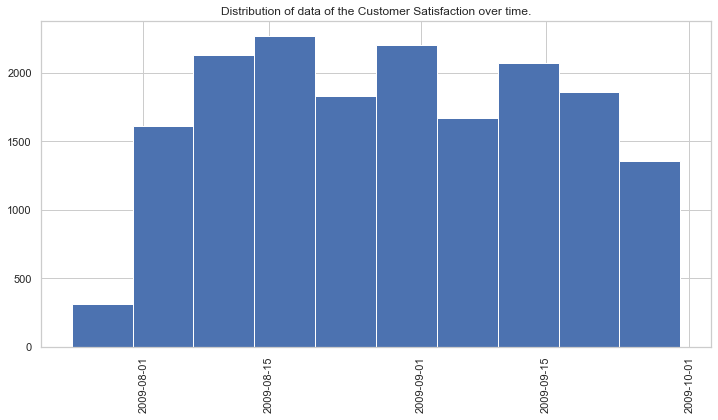

In [4]:
# We notice here, that the Customer Satisfaction dataset goes from the end of July to the end of September
df_cs['cs_date'] = pd.to_datetime(df_cs['cs_date'])

print(f'Start date min is {df_cs["cs_date"].min()}')
print(f'Start date max is {df_cs["cs_date"].max()}')
    
# Have a look to the distribution of the data over time
plt.hist(df_cs["cs_date"])
plt.xticks(rotation=90)
plt.title("Distribution of data of the Customer Satisfaction over time.")
plt.show()

Start date min is 2009-09-01 00:00:00
Start date max is 2009-09-29 00:00:00


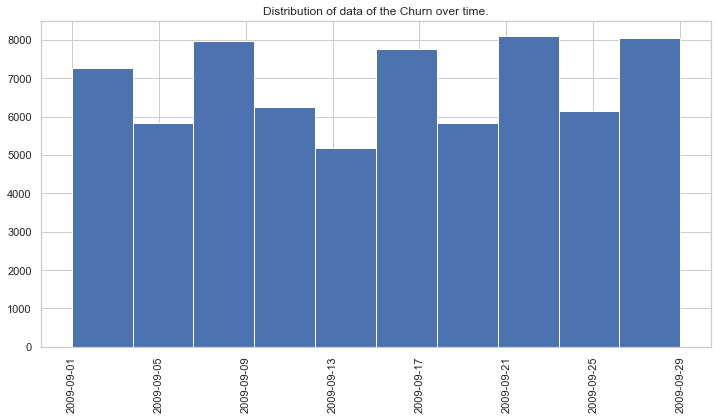

In [5]:
# We notice here, that the Churn dataset concerns the month of September
df_ch['churn_date'] = pd.to_datetime(df_ch['churn_date'], format='%d/%m/%Y')

print(f'Start date min is {df_ch["churn_date"].min()}')
print(f'Start date max is {df_ch["churn_date"].max()}')
    
# Have a look to the distribution of the data over time
plt.hist(df_ch["churn_date"])
plt.xticks(rotation=90)
plt.title("Distribution of data of the Churn over time.")
plt.show()

##  Explore the feature country

In [6]:
# Have a look to the distribution of the contries in the Churn Dataset
df_ch["country"].value_counts()

US    31720
AU    26274
EU    10363
Name: country, dtype: int64

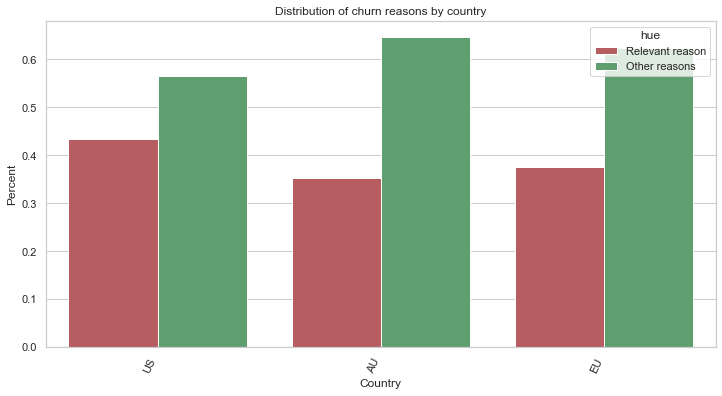

In [7]:
# Here, we will compare the coutries with regards to the reasons of churn
# ... thanks to the separation of the list of reasons into 2 groups
value_counts_global = df_ch["country"].value_counts()

df_ch_unhappy_with_quality_reasons = df_ch[
    df_ch["main_churn_reason_is_quality"] == 1
]
value_count_1 = df_ch_unhappy_with_quality_reasons["country"].value_counts()
value_count_1 = value_count_1 /  (value_counts_global[value_count_1.index].values)

df_ch_unhappy_with_other_reasons = df_ch[
    df_ch["main_churn_reason_is_quality"] == 0
]
value_count_2 = df_ch_unhappy_with_other_reasons["country"].value_counts()
value_count_2 = value_count_2 /  (value_counts_global[value_count_2.index].values)


df_to_viz = pd.DataFrame({
    "Country": list(value_count_1.index) + list(value_count_2.index),
    "Percent": list(value_count_1.values) + list(value_count_2.values),
    "hue": ["Relevant reason"] * len(value_count_1) + ["Other reasons"] * len(value_count_2),
})

chart = sns.barplot(x="Country", y="Percent", hue="hue", data=df_to_viz, 
                 palette={"Other reasons":"g", "Relevant reason":"r"}
                   )
xtick = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')
title = chart.set_title("Distribution of churn reasons by country")


We notice some differences in the distribution when we compare the "relevant reasons" (the reasons in relation with quality), with other reasons.
Specifically, we can say that:
- For the **United-States** customers tend, **more than other countries**, to churn for reasons in relation with quality reasons

## Explore the customer id in the datasets

In [8]:
# Here, we see that there is only one churn by customer 
# ... indeed, it would be a rare event anyway, if a customer churns and then repurchases, and then churns again
list_customer_churn = list(df_ch["customer_id"])
print(f'Number of customers in the churn dataset: {len(list_customer_churn)}')
print(f'Number of unique customers in the churn dataset: {len(set(list_customer_churn))}')

# Here, we see that some customers answer twice the Customer Satisfaction
list_customer_cs = list(df_cs["customer_id"])
print(f'Number of customers in the customer satisfaction dataset: {len(list_customer_cs)}')
print(f'Number of unique customers in the customer satisfaction dataset: {len(set(list_customer_cs))}')

Number of customers in the churn dataset: 68357
Number of unique customers in the churn dataset: 68357
Number of customers in the customer satisfaction dataset: 17328
Number of unique customers in the customer satisfaction dataset: 15408


## Explore the repurchase feature

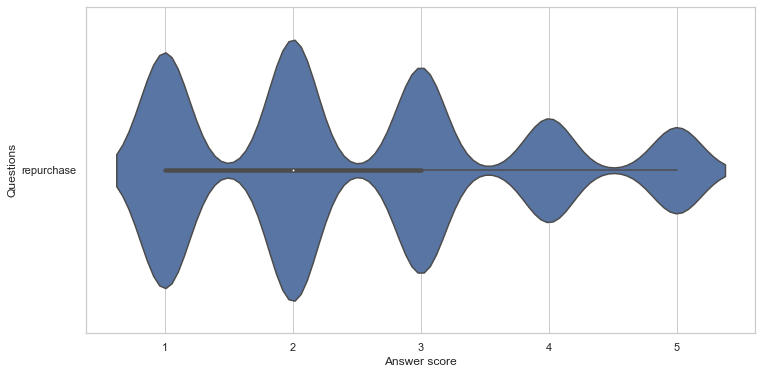

In [9]:
# Visualize the distribution of the answers for the repurchase
df = df_cs[["repurchase"]]
df = df.melt(var_name='Questions', value_name='Answer score')

chart = sns.violinplot(x="Answer score", y="Questions", data=df)


# Other Feature Engineering and Assumptions
We already started our Feature Engineering earlier with filling some empty values.
Here, we continue, with stronger assumptions.

## Assumption about the unanswered repurchase question

We make the assumption that if a customer did not answer this question, the reason can be one the following possibilies:
- Maybe he judges that the question implies an "average" response
- Maybe he did not take the time to do it
- Other reasons

Here, we suppose it is mainly the first reason.
Thus, we fill the repurchase column with the average 3.

In [10]:
# Fill the repurchase field with the average which is 3
df_cs["repurchase"] = df_cs["repurchase"].fillna(3.0)


## Fill other missing values

In [11]:
# Make sure it does not remain any missing values
print(f'Length of the customer satisfaction dataset: {len(df_cs)}')
print(f'Length of non-umpty rows in the customer satisfaction dataset: {len(df_cs[~df_cs.isnull().any(axis=1)])}')

# Drop the rows if few, as there will be no impact on the final results
df_cs = df_cs[~df_cs.isnull().any(axis=1)]

Length of the customer satisfaction dataset: 17328
Length of non-umpty rows in the customer satisfaction dataset: 12992


## Apply some one hot encoding

In [12]:
# Apply one hot encoding for the country
df_cs["country"] = df_cs["country"].astype("category")

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_cs[["country"]])

print(f' The categories are: {enc.categories_}')
enc_df = pd.DataFrame(
    enc.transform(df_cs[["country"]]).toarray(),
    columns = enc.get_feature_names(['country'])
)
# merge with the main dataset
df_cs = df_cs.reset_index(drop=True).join(enc_df)
df_cs.head()

 The categories are: [array(['AU', 'EU', 'US'], dtype=object)]


,cs_date,customer_id,country,quality_delivery_score,quality_ingredient_score,repurchase,country_AU,country_EU,country_US
0,2009-08-01,8266002,EU,10.0,6.0,2.0,0.0,1.0,0.0
1,2009-08-01,8243173,AU,9.0,6.0,2.0,1.0,0.0,0.0
2,2009-08-01,8608885,EU,8.0,6.0,1.0,0.0,1.0,0.0
3,2009-08-01,8186186,AU,10.0,6.0,1.0,1.0,0.0,0.0
4,2009-08-01,8746283,AU,10.0,5.0,1.0,1.0,0.0,0.0


# Build a labeled dataset

## Explore the customers who have answered the Customer Satisfaction and have churned

In [13]:
# Find the customers who have answered the Customer Satisfaction and Churned
df_intersect = pd.merge(df_cs, df_ch[[
    "customer_id",
    "churn_date",
    "main_churn_reason_is_quality",
]], how='inner', left_on="customer_id", right_on="customer_id")
print(len(df_intersect))

# Compute the difference between the churn date and the Customer Satisfaction date
df_intersect["date_diff"] = (df_intersect["churn_date"] - df_intersect["cs_date"]) / np.timedelta64(1, 'D')
df_intersect.head()

2596


,cs_date,customer_id,country,quality_delivery_score,quality_ingredient_score,repurchase,country_AU,country_EU,country_US,churn_date,main_churn_reason_is_quality,date_diff
0,2009-08-01,8187896,AU,8.0,6.0,3.0,1.0,0.0,0.0,2009-09-27,1,57.0
1,2009-08-01,8237922,AU,6.0,6.0,2.0,1.0,0.0,0.0,2009-09-27,0,57.0
2,2009-08-01,8434532,US,6.0,6.0,4.0,0.0,0.0,1.0,2009-09-14,1,44.0
3,2009-09-12,8434532,US,7.0,6.0,4.0,0.0,0.0,1.0,2009-09-14,1,2.0
4,2009-08-01,8180842,US,6.0,6.0,3.0,0.0,0.0,1.0,2009-09-12,0,42.0


The min date: -26.0
The max date: 57.0


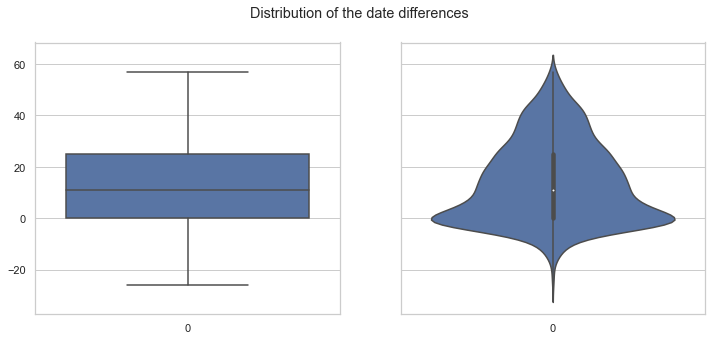

In [14]:
# Show the differences in the dates
print(f'The min date: {df_intersect["date_diff"].min()}')
print(f'The max date: {df_intersect["date_diff"].max()}')

# Visualize the date distribution
fig, axes = plt.subplots(1, 2, figsize=(PLOT_WIDTH, 5), sharey=True)
fig.suptitle('Distribution of the date differences')

sns.boxplot(ax=axes[0], data=df_intersect["date_diff"])
sub_title = axes[0].set_title("")

sns.violinplot(ax=axes[1], data=df_intersect["date_diff"])
sub_title = axes[1].set_title("")


## Build the dataset of customers who churn

In [15]:
# Here, we prepare the dataset for customers who churn (with their Customer Satisfaction informations)
# ... we filter on the events that happened between 0 and 6 days
df_ch_yes = df_intersect[((df_intersect["date_diff"] >=0) &
                        (df_intersect["date_diff"] <=6))]


df_ch_yes.drop(columns=[
    "churn_date",
    "date_diff",
], axis=1, inplace=True)

# Add a column about the status
df_ch_yes["will_churn"] = 1
print(f'Remaining rows: {len(df_ch_yes)}')

# We filter on the "relevant" reasons!
df_ch_yes = df_ch_yes[df_ch_yes["main_churn_reason_is_quality"] == 1]
print(f'Remaining rows: {len(df_ch_yes)}')

df_ch_yes.sample(5)

Remaining rows: 528
Remaining rows: 311


/Users/nabil.belaid/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-15-74916e0f4e4c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ch_yes["will_churn"] = 1


,cs_date,customer_id,country,quality_delivery_score,quality_ingredient_score,repurchase,country_AU,country_EU,country_US,main_churn_reason_is_quality,will_churn
1349,2009-09-02,8134774,EU,7.0,5.0,5.0,0.0,1.0,0.0,1,1
2428,2009-09-24,8346480,AU,10.0,6.0,3.0,1.0,0.0,0.0,1,1
2052,2009-09-15,8103548,US,5.0,4.0,3.0,0.0,0.0,1.0,1,1
1284,2009-08-31,8146873,EU,10.0,8.0,1.0,0.0,1.0,0.0,1,1
2143,2009-09-17,8639838,EU,7.0,4.0,4.0,0.0,1.0,0.0,1,1


## Build the dataset of customers who did not churn

In [16]:
# Here, we prepare the dataset for customers who did not churn (with their Customer Satisfaction informations)
# ... we filter on the Customer Satisfaction that will enable us to validate that the customer did not churn indeed
df_ch_no = df_cs
df_ch_no = df_ch_no[df_ch_no["cs_date"] >= datetime.datetime(2009, 9, 1)]
df_ch_no = df_ch_no[df_ch_no["cs_date"] < datetime.datetime(2009, 9, 23)]
print(f'Remaining rows: {len(df_ch_no)}')

l_customer_to_put_out = list(df_intersect["customer_id"])
df_ch_no = df_ch_no[~df_ch_no["customer_id"].isin(l_customer_to_put_out)]

# Add a column about the status
df_ch_no["will_churn"] = 0
print(f'Remaining rows: {len(df_ch_no)}')

df_ch_no.sample(5)

Remaining rows: 4455
Remaining rows: 3302


,cs_date,customer_id,country,quality_delivery_score,quality_ingredient_score,repurchase,country_AU,country_EU,country_US,will_churn
9076,2009-09-11,8177493,US,8.0,6.0,3.0,0.0,0.0,1.0,0
9579,2009-09-12,8085999,EU,8.0,6.0,2.0,0.0,1.0,0.0,0
8608,2009-09-09,8390656,US,6.0,7.0,2.0,0.0,0.0,1.0,0
8517,2009-09-08,8104329,EU,6.0,6.0,2.0,0.0,1.0,0.0,0
7349,2009-09-02,8113875,AU,6.0,5.0,3.0,1.0,0.0,0.0,0


## Compare the 2 dataset with regards to their caracteristiques

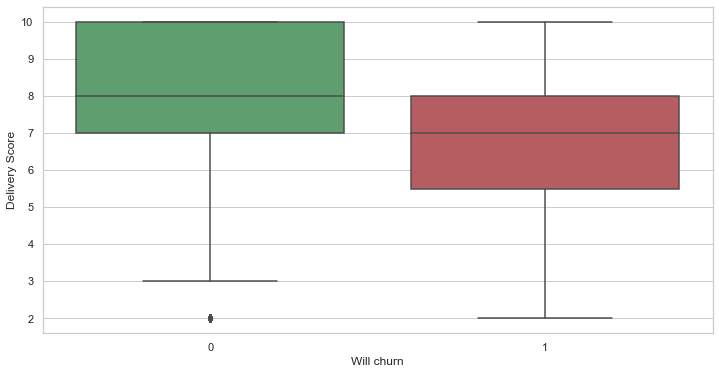

In [17]:
# Compare the 2 dataset with regards to their delivery scores
# We see that there is indeed a tendency of worse scores for customers who churn
df_to_viz = pd.DataFrame({
    "Delivery Score": list(df_ch_yes["quality_delivery_score"]) + list(df_ch_no["quality_delivery_score"]),
    "Will churn": list(df_ch_yes["will_churn"]) + list(df_ch_no["will_churn"]),
})
graph = sns.boxplot(x='Will churn', y='Delivery Score', data=df_to_viz, 
                    palette={0:"g", 1:"r"})



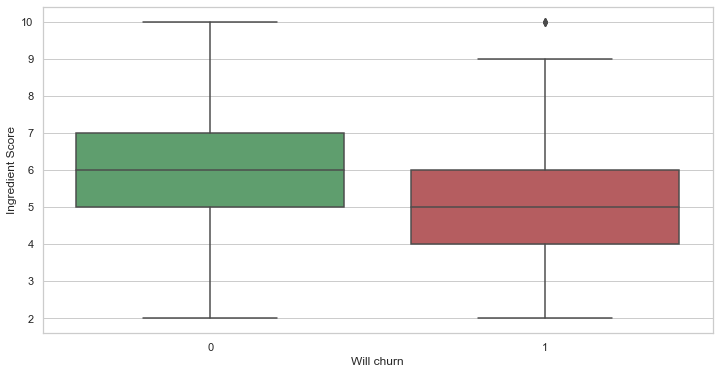

In [18]:
# Compare the 2 dataset with regards to their ingredient scores 
# We see that there is indeed a tendency of worse scores for customers who churn
df_to_viz = pd.DataFrame({
    "Ingredient Score": list(df_ch_yes["quality_ingredient_score"]) + list(df_ch_no["quality_ingredient_score"]),
    "Will churn": list(df_ch_yes["will_churn"]) + list(df_ch_no["will_churn"]),
})
graph = sns.boxplot(x='Will churn', y='Ingredient Score', data=df_to_viz, 
                    palette={0:"g", 1:"r"})



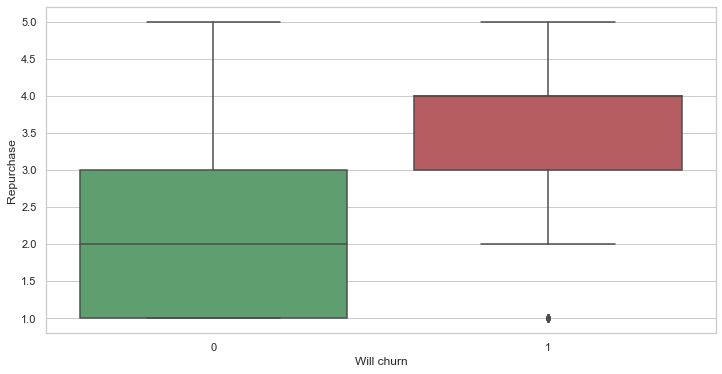

In [19]:
# Compare the 2 dataset with regards to their answer about repurchase
# There is indeed a tendency of not repurchasing when they churn (high score is worse here)
df_to_viz = pd.DataFrame({
    "Repurchase": list(df_ch_yes["repurchase"]) + list(df_ch_no["repurchase"]),
    "Will churn": list(df_ch_yes["will_churn"]) + list(df_ch_no["will_churn"]),
})
graph = sns.boxplot(x='Will churn', y='Repurchase', data=df_to_viz, 
                    palette={0:"g", 1:"r"})
#title = graph.set_title("...repurchase")



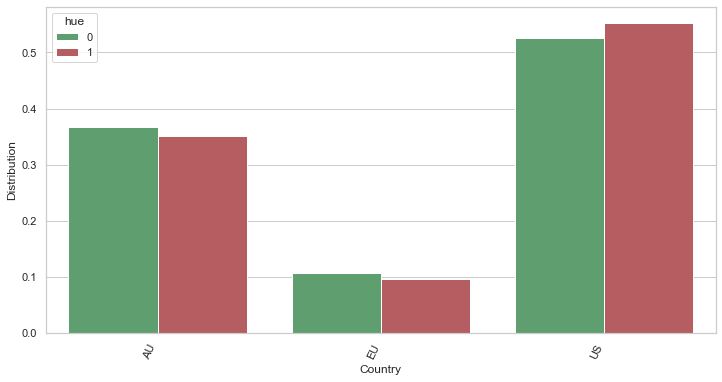

In [20]:
# Here, we compare the districution of the churn and not churn with regards to the country
df_ch_yes_fc = df_ch_yes[["country","will_churn",]]
df_ch_yes_fc_gp = df_ch_yes_fc.groupby(["country"]).count()
df_ch_yes_fc_gp = df_ch_yes_fc_gp.rename(columns={"will_churn":"count"}).reset_index()
df_ch_yes_fc_gp["mean_occ"] = df_ch_yes_fc_gp["count"] / len(df_ch_yes)
df_ch_yes_fc_gp["will_churn"] = 1

df_ch_no_fc = df_ch_no[["country","will_churn",]]
df_ch_no_fc_gp = df_ch_no_fc.groupby(["country"]).count()
df_ch_no_fc_gp = df_ch_no_fc_gp.rename(columns={"will_churn":"count"}).reset_index()
df_ch_no_fc_gp["mean_occ"] = df_ch_no_fc_gp["count"] / len(df_ch_no)
df_ch_no_fc_gp["will_churn"] = 0


df_to_viz = pd.DataFrame({
    "Country": list(df_ch_yes_fc_gp["country"]) + list(df_ch_no_fc_gp["country"]),
    "Distribution": list(df_ch_yes_fc_gp["mean_occ"]) + list(df_ch_no_fc_gp["mean_occ"]),
    "hue": list(df_ch_yes_fc_gp["will_churn"]) + list(df_ch_no_fc_gp["will_churn"]),
})

chart = sns.barplot(x="Country", y="Distribution", hue="hue", data=df_to_viz, 
                 palette={0:"g", 1:"r"})
xtick = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')


## Build finally the labelled dataset

In [21]:
# Merge the 2 datasets
df_ch_yes = df_ch_yes[df_ch_no.columns]
frames = [df_ch_yes, df_ch_no]
df_model = pd.concat(frames)
df_model = df_model.iloc[np.random.permutation(len(df_model))]
df_model.sample(5)

,cs_date,customer_id,country,quality_delivery_score,quality_ingredient_score,repurchase,country_AU,country_EU,country_US,will_churn
10282,2009-09-16,8077557,AU,10.0,6.0,1.0,1.0,0.0,0.0,0
10703,2009-09-18,8551731,US,10.0,6.0,1.0,0.0,0.0,1.0,0
8146,2009-09-06,8774194,EU,7.0,5.0,3.0,0.0,1.0,0.0,0
10074,2009-09-15,8094770,US,9.0,7.0,2.0,0.0,0.0,1.0,0
541,2009-09-19,8202006,US,3.0,5.0,5.0,0.0,0.0,1.0,1


In [22]:
# Let us get the distribution cases
print(f'Total number of rows: {len(df_model)}')
print(f'The distribution of cases is:')
value_counts = df_model["will_churn"].value_counts()
print(value_counts)
print(f'The proportion of churn cases is {value_counts[1] / value_counts.values.sum()}')


Total number of rows: 3613
The distribution of cases is:
0    3302
1     311
Name: will_churn, dtype: int64
The proportion of churn cases is 0.0860780514807639


# Build a Model for churn prediction

Here, we use the labeled dataset to build a model that will predict if a customer churns based on the Customer Satisfaction questions he answers.
Note that the dataset is unbalanced.

As we want to detect the maximum of customers who will churn, we will focus on miximizing the **recall**.
However, we have to keep the **precision** and **percentage of predicted "positive" customers** at acceptable values.

## A Dummy Model
Here, we start with a dummy model.
Indeed, as we observed, the average score of the "repurchase" question is different for the customers who churn and for the ones who do not.
Thus, let us build a simple dummy model that is exclusively based on this feature.


In [23]:
split_list = [5.0, 4.0, 3.0]

for split in split_list:
    print(f'Performances when we only contact customer who have answered at least {split} on the repurchase question ---------- ')
    y_pred = (df_model["repurchase"] >= split) * 1
    y_true = df_model["will_churn"]
    print(f'Number of customer to investigate: {round(y_pred.sum(),3)}')
    print(f'Proportion of customer to investigate: {round(y_pred.sum() / len(df_model),3)}')

    print(f'Accuracy of the dummy model: {round(accuracy_score(y_true, y_pred),3)}')
    print(f'Precision of the dummy model: {round(precision_score(y_true, y_pred, zero_division=0),3)}')
    print(f'Recall of the dummy model: {round(recall_score(y_true, y_pred, zero_division=0),3)}')
    print()

Performances when we only contact customer who have answered at least 5.0 on the repurchase question ---------- 
Number of customer to investigate: 175
Proportion of customer to investigate: 0.048
Accuracy of the dummy model: 0.904
Precision of the dummy model: 0.4
Recall of the dummy model: 0.225

Performances when we only contact customer who have answered at least 4.0 on the repurchase question ---------- 
Number of customer to investigate: 534
Proportion of customer to investigate: 0.148
Accuracy of the dummy model: 0.855
Precision of the dummy model: 0.3
Recall of the dummy model: 0.514

Performances when we only contact customer who have answered at least 3.0 on the repurchase question ---------- 
Number of customer to investigate: 1347
Proportion of customer to investigate: 0.373
Accuracy of the dummy model: 0.683
Precision of the dummy model: 0.191
Recall of the dummy model: 0.826



We see that for example if we contact all customers that answered at least 4 in to repurchase question, we would end up contacting 15% of the total customers, and only reach 51% of the customers who will churn.
However, if we contact all customers that answered at least 3 in to repurchase question, we would end up contacting 37% of the total customers, but we would reach 82% of the customers who will churn.

## A little more complex models
Here, we build a Machine Learning Classification Model that will maximize the recall while maintaining certain performances with regards to the maximum percentage of customers to investigate.

In [33]:
# Here are the features that we keep according to our analysis
id_column = "customer_id"
target_column = "will_churn"
features_columns = [
    "repurchase",
    "quality_delivery_score",
    "quality_ingredient_score",
    #"country_AU",
    #"country_EU",
    #"country_US",
]


In [34]:
# This is long helper function
# The objective is compute the performances of the models taking into account the following requirements:
# 1) We want our results to be cross validated
# 2) We want to do it statified-wise
# 3) As the data is unbalances, we want to perform a resampling
def cross_validate(
    model, 
    df_model: pd.DataFrame,
    features_columns: List[str],
    target_column: str,
    number_splits: int = 5,
    max_percent: float = 0.8) -> Tuple[float, float, float]:

    # These lists will contain the evaluations of each folds
    list_accuracy = []
    list_precision = []
    list_recall = []
    list_percent = []
    list_threshold = []

    # Split stratified-wise
    stratified_k_fold = StratifiedKFold(n_splits=number_splits, shuffle=True)
    index_pairs_folds = stratified_k_fold.split(df_model[features_columns], df_model[target_column])

    # For each fold, get the indexes of the train and test dataset
    for index_train, index_test in index_pairs_folds:
        #  Get the train and test dataset, from their indexes
        df_train = df_model.iloc[index_train]
        df_test = df_model.iloc[index_test]
        
        # Compte X y for train and test
        X_train = df_train[features_columns]
        y_train_true = df_train[target_column]        
        X_test = df_test[features_columns]
        y_test_true = df_test[target_column]

        # Apply a resampling for the train dataset only
        sampler_adasyn = ADASYN(random_state=RANDOM_STATE)
        X_train_resampled, y_train_true_resampled = sampler_adasyn.fit_sample(
            X_train, y_train_true)

        # Run the model (with the resampled X and y train)
        model.fit(X_train_resampled, y_train_true_resampled)

        # Get the predictions
        y_test_pred_proba = model.predict_proba(X_test)
        y_test_pred_0 = pd.Series([row[0] for row in y_test_pred_proba])

        # Compute the following metrics of this fold (with regards to the max_percentage required)
        accuracy, precision, recall, percent, threshold = optimize_threshold_for_precision(
            df_test, 
            y_test_true, 
            y_test_pred_0, 
            np.arange(0, 1.1, 0.1),
            max_percent)

        print(f'Best metrics for this fold are '+
                f'Accuracy: {round(accuracy, 3)}, Precision: {round(precision, 3)}, '+
                f'Recall: {round(recall, 3)}, Percent: {round(percent, 3)}, Threshold: {round(threshold, 3)}.')

        list_accuracy.append(accuracy)
        list_precision.append(precision)
        list_recall.append(recall)
        list_percent.append(percent)
        list_threshold.append(threshold)

    # Compute the average of each metric
    mean_accuracy = round(float(np.mean(list_accuracy)), 3)
    mean_precision = round(float(np.mean(list_precision)), 3)
    mean_recall = round(float(np.mean(list_recall)), 3)
    mean_percent = round(float(np.mean(list_percent)), 3)
    mean_threshold = round(float(np.mean(list_threshold)), 3)

    print(f'Final mean results are '+
            f'Accuracy: {mean_accuracy}, Precision: {mean_precision}, ' +
            f'Recall: {mean_recall}, Percent: {mean_percent}, Threshold: {mean_threshold}.')

    #return mean_accuracy, mean_precision, mean_recall, mean_percent

# This function computes the metric
def optimize_threshold_for_precision(
    df_test: pd.DataFrame,
    y_test_true: np.ndarray, 
    y_test_pred_0: np.ndarray,
    threshold_range: Iterable[float], 
    max_percent: float) -> Tuple[float, int, float, int]:
 
    best_recall = 0.
    accuracy_for_best_recall = 0.
    precision_for_best_recall = 0.
    percent_for_best_recall = 0.
    threshold_for_best_recall = 0.
    
    # In order to compute the best metrics (with regards to the max percentage required), we make the threshold vary
    for threshold in threshold_range:
        # First, compute the predicted classes (thanks to the threshold)
        y_test_pred = np.where(y_test_pred_0 >= threshold, 0, 1)

        # Get the metrics
        accuracy = accuracy_score(y_test_true, y_test_pred)
        precision = precision_score(y_test_true, y_test_pred, zero_division=0)
        recall = recall_score(y_test_true, y_test_pred, zero_division=0)
        percent = y_test_pred.sum() / len(y_test_pred)

        # Keep the best performances
        if recall >= best_recall and percent <= max_percent:
            best_recall = recall
            accuracy_for_best_recall = accuracy
            precision_for_best_recall = precision
            percent_for_best_recall = percent
            threshold_for_best_recall = threshold

    return accuracy_for_best_recall, precision_for_best_recall, best_recall, percent_for_best_recall, threshold_for_best_recall


In [35]:
dict_models = {
    "LogisticRegression": LogisticRegression(max_iter=10000),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, min_samples_leaf=4, max_depth=10),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
}

for name, model in dict_models.items():  
    print(f'Compute metrics for the {name} model ---------- ')

    # Call the function that computes the performanes
    # ... We are requiring a maximum of X% percent of customers to investigate
    # ... Here, we require a maximum of 30% 
    cross_validate(
      model, 
      df_model, 
      features_columns, 
      target_column,
      number_splits = 5,
      max_percent = 0.3)
    print()

Compute metrics for the LogisticRegression model ---------- 
Best metrics for this fold are Accuracy: 0.804, Precision: 0.247, Recall: 0.629, Percent: 0.219, Threshold: 0.4.
Best metrics for this fold are Accuracy: 0.826, Precision: 0.258, Recall: 0.548, Percent: 0.183, Threshold: 0.4.
Best metrics for this fold are Accuracy: 0.858, Precision: 0.328, Recall: 0.603, Percent: 0.16, Threshold: 0.4.
Best metrics for this fold are Accuracy: 0.839, Precision: 0.289, Recall: 0.597, Percent: 0.177, Threshold: 0.4.
Best metrics for this fold are Accuracy: 0.791, Precision: 0.197, Recall: 0.468, Percent: 0.204, Threshold: 0.4.
Final mean results are Accuracy: 0.823, Precision: 0.264, Recall: 0.569, Percent: 0.188, Threshold: 0.4.

Compute metrics for the RandomForestClassifier model ---------- 
Best metrics for this fold are Accuracy: 0.784, Precision: 0.23, Recall: 0.645, Percent: 0.241, Threshold: 0.5.
Best metrics for this fold are Accuracy: 0.773, Precision: 0.217, Recall: 0.629, Percent: 0.

We notice that the Random Forest Model gives the best performances.
Specifically, for the Random Forest, it gives a recall of 68% if we require to investigate only 26% of the customers.

We noticed that a dummy model already gives good performances.
Indeed, we had already noticed a significant difference between the distribution of the repurchase answers for the customers who churn and for the one who did not churn.
We would then advice basing on a more complex model only if we want a fine-grained set of customers to investigate.

# Next steps
Here are some of the next steps with regards to this study:
- Acquiring more data (a lot more)
- With more data, perform the analysis separately for each market. 
- About a production-ready solution, we could build a pipeline that streams the data in and predicts on the fly the probability of churn, and then applies the best automatic action (promotion mails, etc.). Another option is generating a list of "sensitive" customers every morning, and performing "manual" actions, such as calling them.
- Applying calibration on the classification models
- Run automatic features selection to optimize the performances
- Try other types of models such as Anomaly Detection, or Regression on the repurchase feature.
